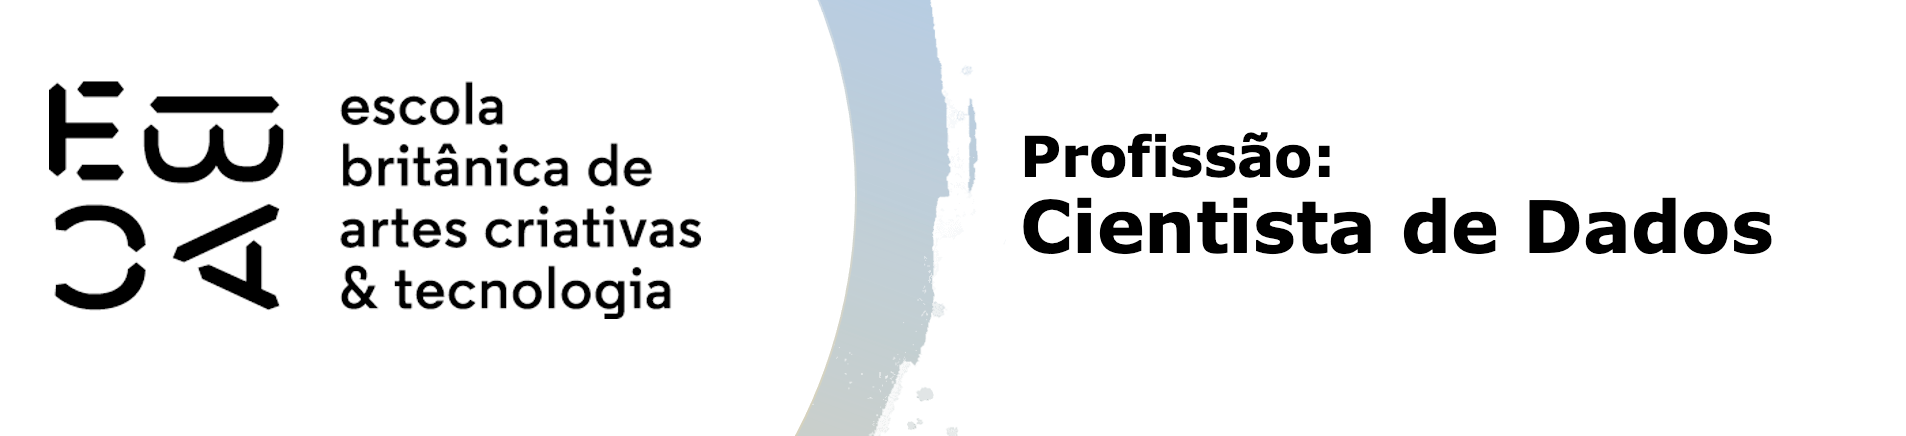

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

import warnings; warnings.filterwarnings('ignore')

In [2]:
df = pd.read_feather('credit_scoring.ftr')
display(df.head())

print('Verificando o alcance das datas DataFrame Completo:')
display(df.data_ref.unique())

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


Verificando o alcance das datas DataFrame Completo:


<DatetimeArray>
['2015-01-01 00:00:00', '2015-02-01 00:00:00', '2015-03-01 00:00:00',
 '2015-04-01 00:00:00', '2015-05-01 00:00:00', '2015-06-01 00:00:00',
 '2015-07-01 00:00:00', '2015-08-01 00:00:00', '2015-09-01 00:00:00',
 '2015-10-01 00:00:00', '2015-11-01 00:00:00', '2015-12-01 00:00:00',
 '2016-01-01 00:00:00', '2016-02-01 00:00:00', '2016-03-01 00:00:00']
Length: 15, dtype: datetime64[ns]

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.

In [3]:
# Amostra
dataset = df.sample(50000)
dataset.drop(['data_ref','index'], axis=1, inplace=True)

print('Informações das variáveis de amostragem:\n')
display(dataset.info())

Informações das variáveis de amostragem:

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 605071 to 343755
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sexo                   50000 non-null  object 
 1   posse_de_veiculo       50000 non-null  object 
 2   posse_de_imovel        50000 non-null  object 
 3   qtd_filhos             50000 non-null  int64  
 4   tipo_renda             50000 non-null  object 
 5   educacao               50000 non-null  object 
 6   estado_civil           50000 non-null  object 
 7   tipo_residencia        50000 non-null  object 
 8   idade                  50000 non-null  int64  
 9   tempo_emprego          41640 non-null  float64
 10  qt_pessoas_residencia  50000 non-null  float64
 11  renda                  50000 non-null  float64
 12  mau                    50000 non-null  bool   
dtypes: bool(1), float64(3), int64(2), object(7)
memory usage: 5.0+ 

None

In [4]:
## Validação - selecionando 3 ultimos meses
df_valid = df.set_index('data_ref')

df_valid = df_valid['2016-01-01':]
df_valid.reset_index(inplace=True)

print('\nDados Validação:')
display(df_valid.head(3))
print('\nInformações das variáveis de Validação:')
display(df_valid.info())
print('\n\nAlcance das datas de Validação:')
display(df_valid.data_ref.unique())


Dados Validação:


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2016-01-01,8906,F,S,S,2,Assalariado,Superior completo,Casado,Casa,38,7.383562,4.0,2969.49,True
1,2016-01-01,5063,F,N,S,0,Assalariado,Médio,Casado,Casa,55,8.471233,2.0,6278.37,False
2,2016-01-01,16401,M,S,S,1,Assalariado,Médio,União,Casa,39,8.884932,3.0,14010.18,False



Informações das variáveis de Validação:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               150000 non-null  datetime64[ns]
 1   index                  150000 non-null  int64         
 2   sexo                   150000 non-null  object        
 3   posse_de_veiculo       150000 non-null  object        
 4   posse_de_imovel        150000 non-null  object        
 5   qtd_filhos             150000 non-null  int64         
 6   tipo_renda             150000 non-null  object        
 7   educacao               150000 non-null  object        
 8   estado_civil           150000 non-null  object        
 9   tipo_residencia        150000 non-null  object        
 10  idade                  150000 non-null  int64         
 11  tempo_emprego          124918 non-null  float64       
 12  qt_

None



Alcance das datas de Validação:


<DatetimeArray>
['2016-01-01 00:00:00', '2016-02-01 00:00:00', '2016-03-01 00:00:00']
Length: 3, dtype: datetime64[ns]

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

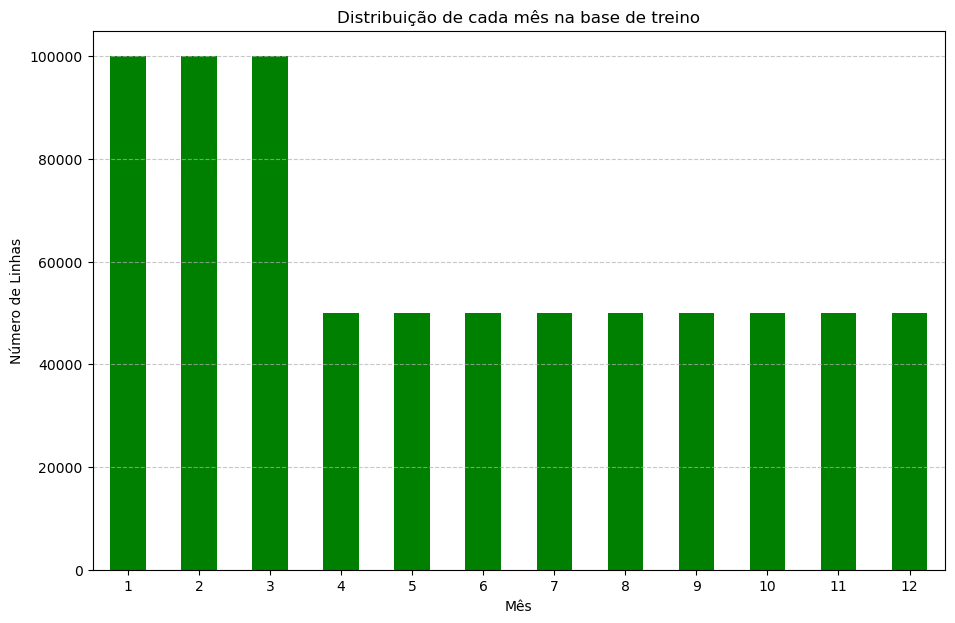

In [5]:
df_1 = df.copy()
df_1['mes'] = df_1['data_ref'].dt.month

count_by_month = df_1['mes'].value_counts().sort_index()

# Verificando a distribuição dos dados
plt.figure(figsize=(11, 7))
count_by_month.plot(kind='bar', color='green')
plt.title('Distribuição de cada mês na base de treino')
plt.xlabel('Mês')
plt.ylabel('Número de Linhas')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

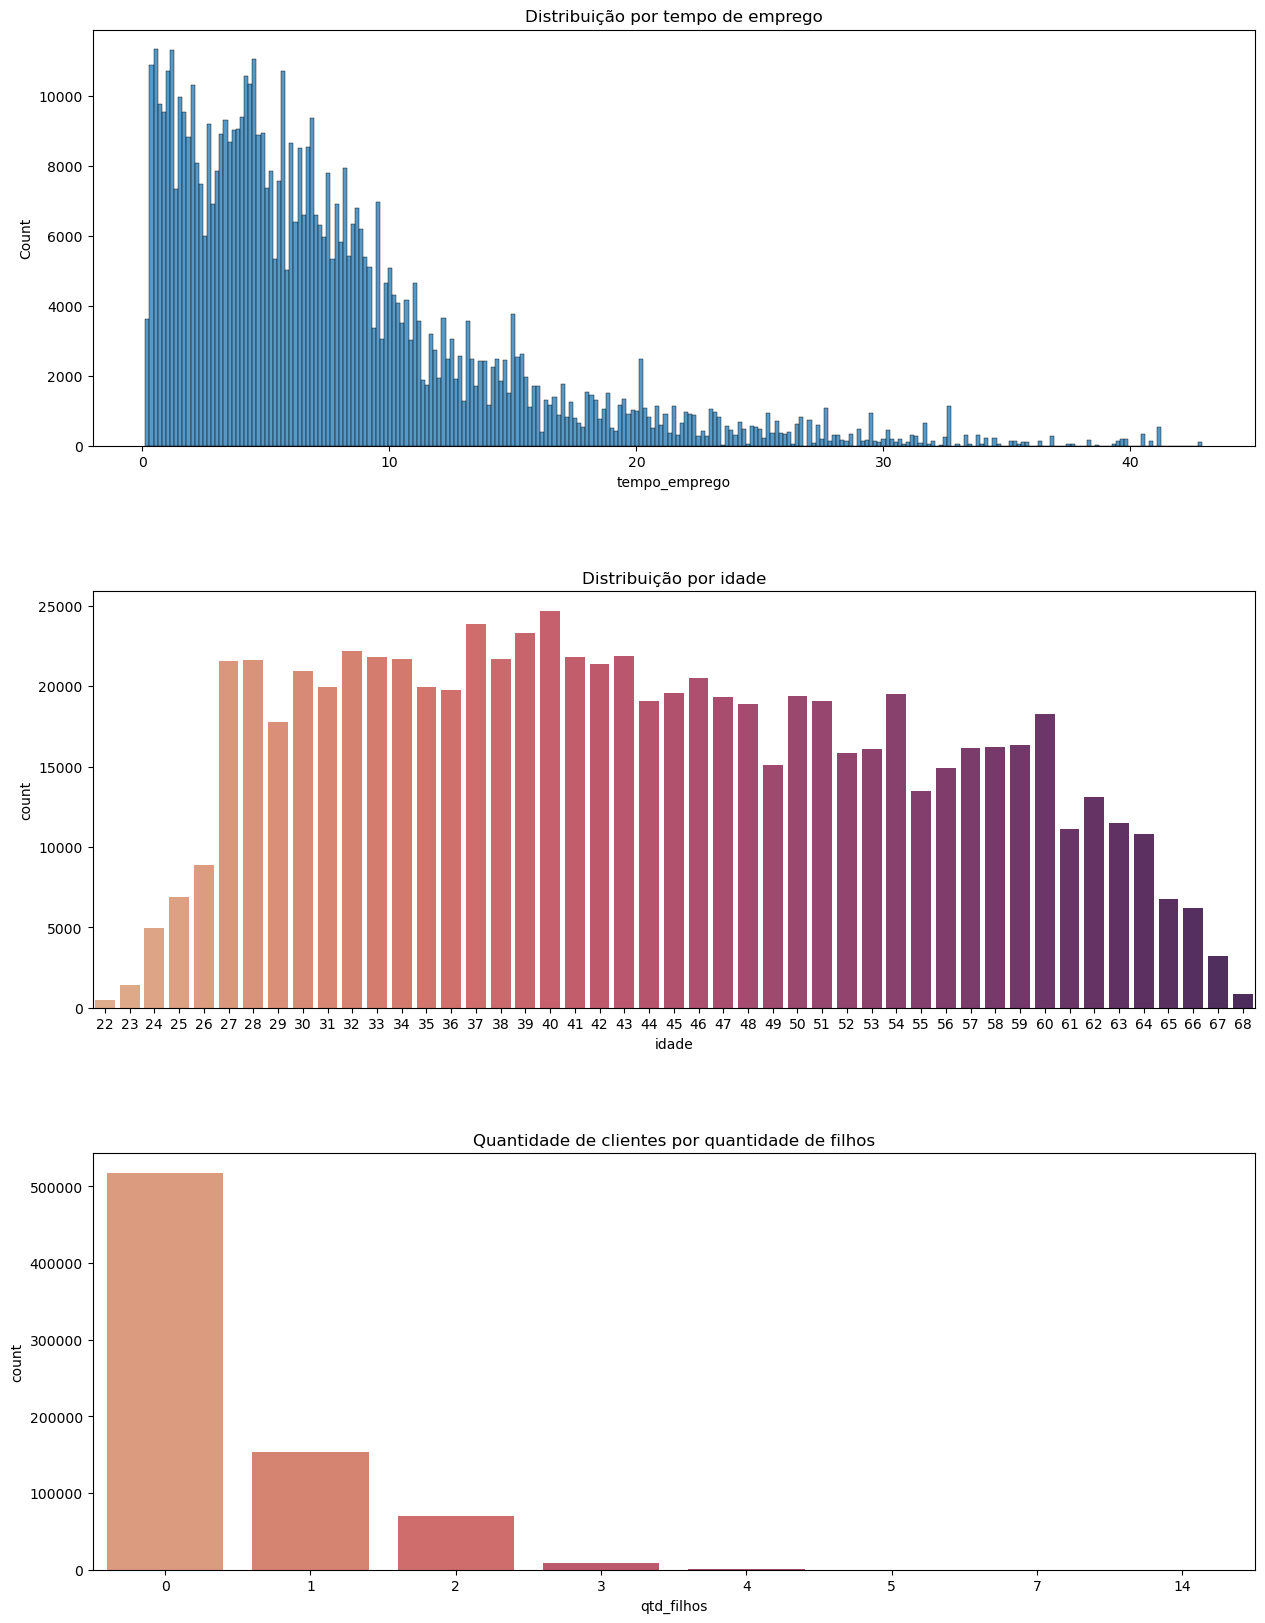

In [6]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 20))

sns.histplot(data=df_1, x='tempo_emprego', ax=ax[0])
ax[0].set_title('Distribuição por tempo de emprego')

sns.countplot(data=df_1, x='idade', palette='flare', ax=ax[1])
ax[1].set_title('Distribuição por idade')

sns.countplot(data=df_1, x='qtd_filhos', palette='flare', ax=ax[2])
ax[2].set_title('Quantidade de clientes por quantidade de filhos')


plt.subplots_adjust(hspace=0.35)
plt.show()

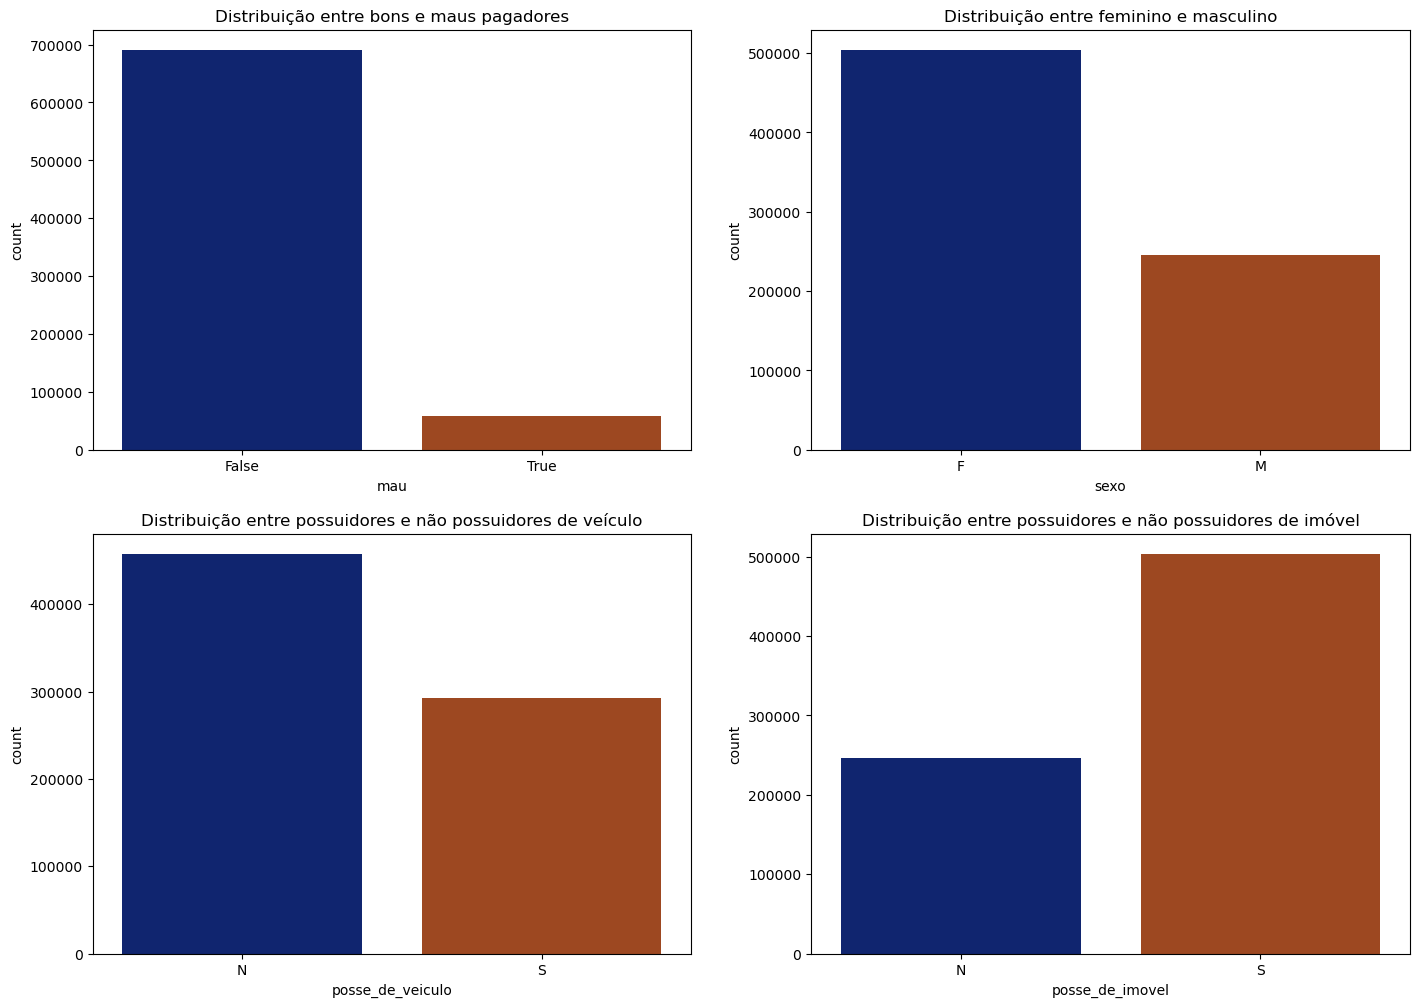

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(17, 12))

sns.countplot(data=df_1, x='mau', palette='dark', ax=ax[0, 0])
ax[0, 0].set_title('Distribuição entre bons e maus pagadores')

sns.countplot(data=df_1, x='sexo', palette='dark', ax=ax[0, 1])
ax[0, 1].set_title('Distribuição entre feminino e masculino')

sns.countplot(data=df_1, x='posse_de_veiculo', palette='dark', ax=ax[1, 0])
ax[1, 0].set_title('Distribuição entre possuidores e não possuidores de veículo')

sns.countplot(data=df_1, x='posse_de_imovel', palette='dark', ax=ax[1, 1])
ax[1, 1].set_title('Distribuição entre possuidores e não possuidores de imóvel')
plt.show()

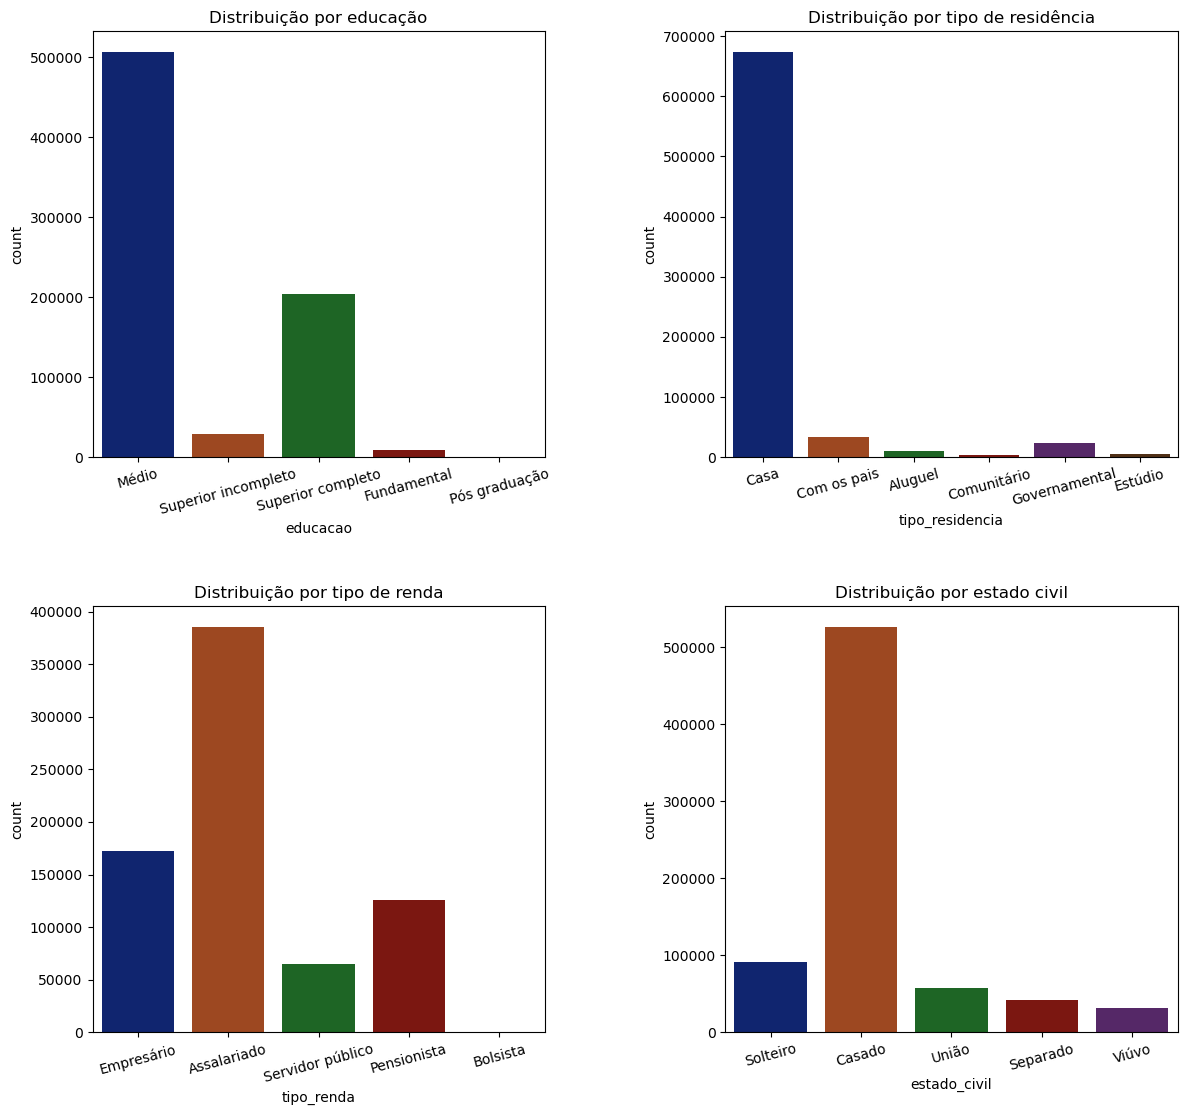

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 13))

sns.countplot(data=df_1, x='educacao', palette='dark', ax=ax[0, 0])
ax[0, 0].set_title('Distribuição por educação')
for tick in ax[0, 0].get_xticklabels():
    tick.set_rotation(15)
    
sns.countplot(data=df_1, x='tipo_residencia', palette='dark', ax=ax[0, 1])
ax[0, 1].set_title('Distribuição por tipo de residência')
for tick in ax[0, 1].get_xticklabels():
    tick.set_rotation(15)
    
sns.countplot(data=df_1, x='tipo_renda', palette='dark', ax=ax[1, 0])
ax[1, 0].set_title('Distribuição por tipo de renda')
for tick in ax[1, 0].get_xticklabels():
    tick.set_rotation(15)

sns.countplot(data=df_1, x='estado_civil', palette='dark', ax=ax[1, 1])
ax[1, 1].set_title('Distribuição por estado civil')
for tick in ax[1, 1].get_xticklabels():
    tick.set_rotation(15)

plt.subplots_adjust(wspace=0.4, hspace=0.35)
plt.show()

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

Text(0.5, 1.0, 'Distribuição: MAU X RENDA')

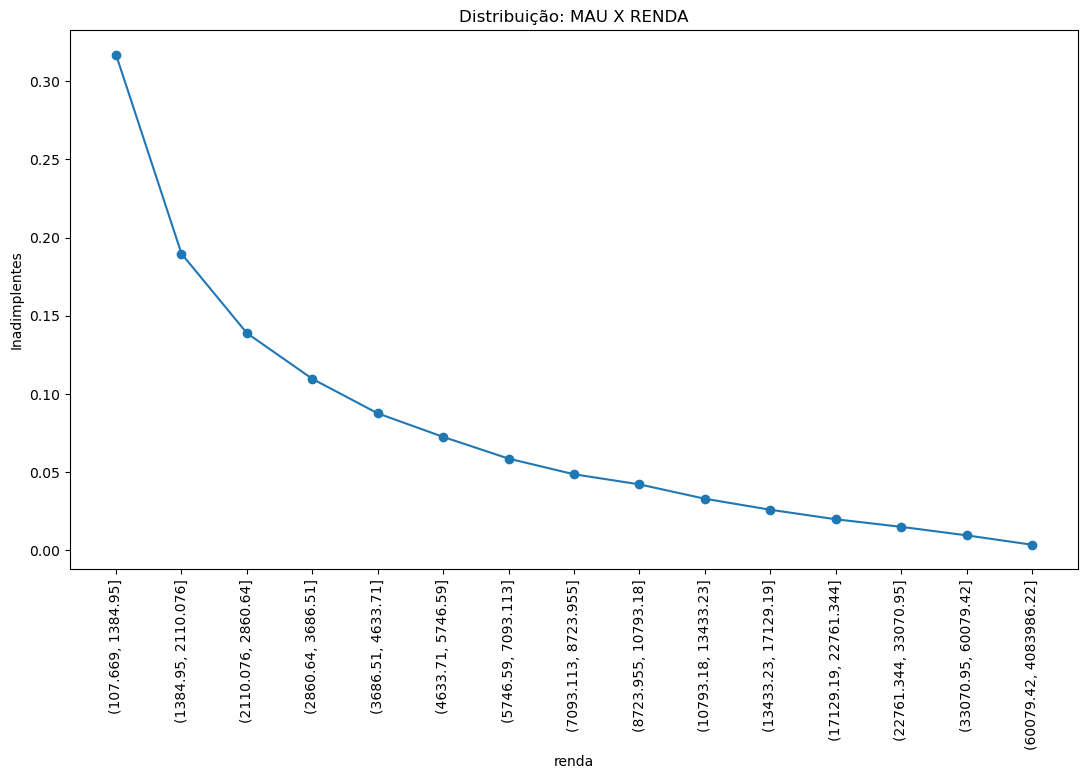

In [9]:
fig, ax = plt.subplots(figsize=(13, 7))

cat_, bins = pd.qcut(df_1['renda'], 15, retbins=True)
df_ = df_1.groupby(cat_)
biv = df_['mau'].mean()

ax = biv.plot.line(marker='o')
ax.set_ylabel("Inadimplentes")
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation=90)
ax.set_title('Distribuição: MAU X RENDA')

Text(0.5, 1.0, 'Distribuição: MAU X IDADE')

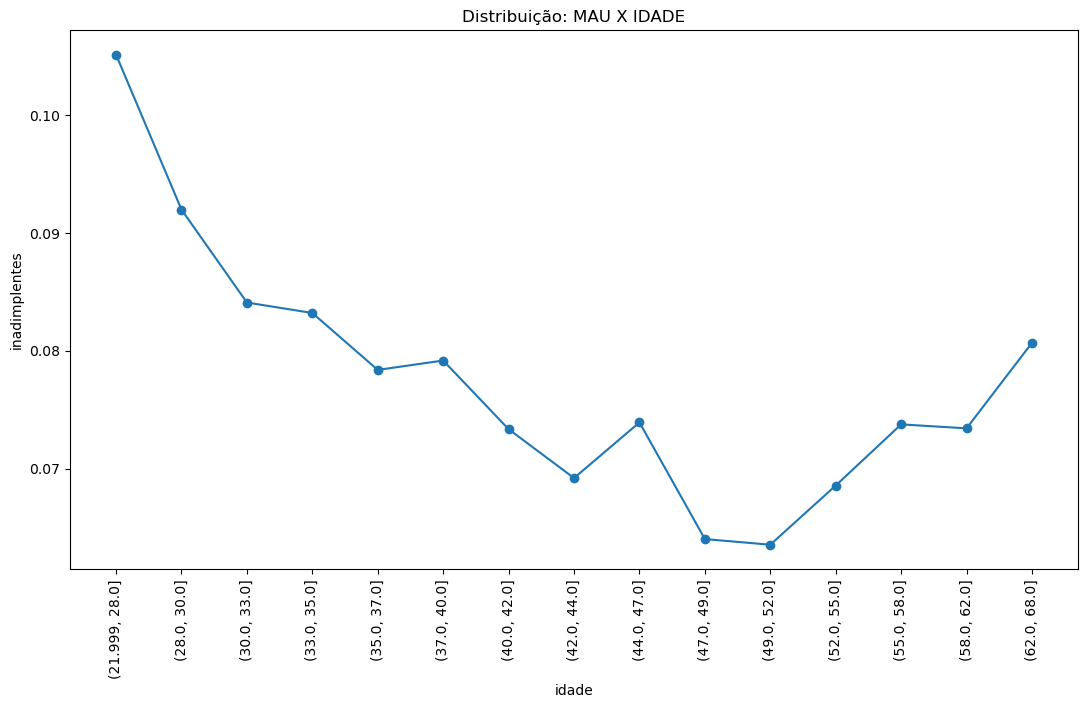

In [10]:
fig, ax = plt.subplots(figsize=(13, 7))

cat_2, bins = pd.qcut(df_1['idade'], 15, retbins=True)
df_2 = df_1.groupby(cat_2)
biv = df_2['mau'].mean()

ax = biv.plot.line(marker='o')
ax.set_ylabel("inadimplentes")
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation=90)
ax.set_title('Distribuição: MAU X IDADE')

Text(0.5, 1.0, 'Distribuição de MAU no tempo')

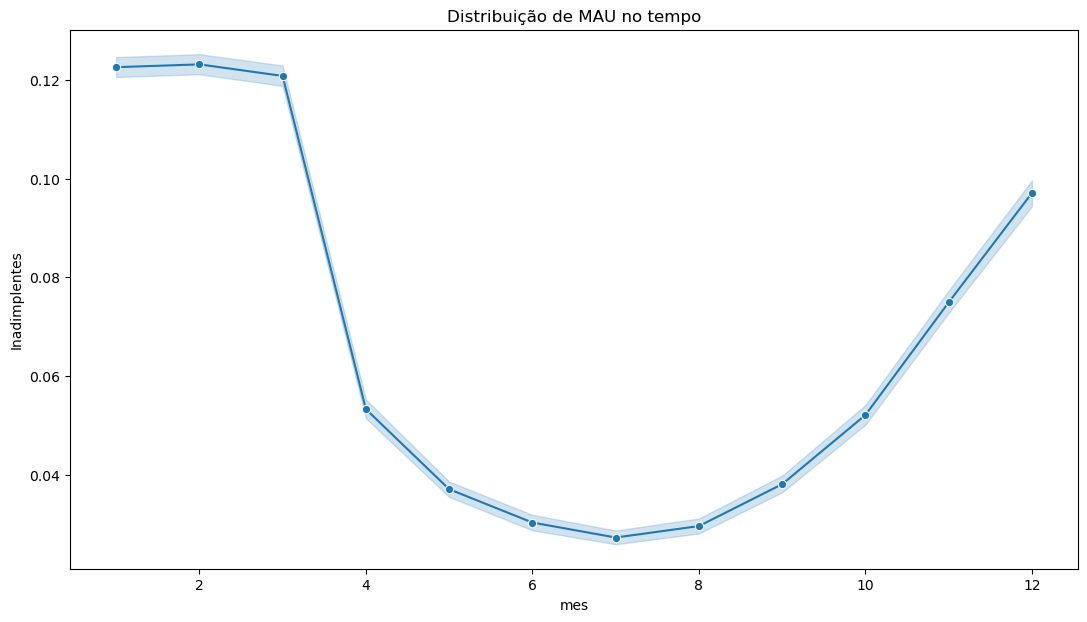

In [11]:
fig, ax = plt.subplots(figsize=(13,7))
sns.lineplot(data=df_1, x='mes', y='mau', ax=ax, marker='o')
ax.set_ylabel("Inadimplentes")
ax.set_title('Distribuição de MAU no tempo')

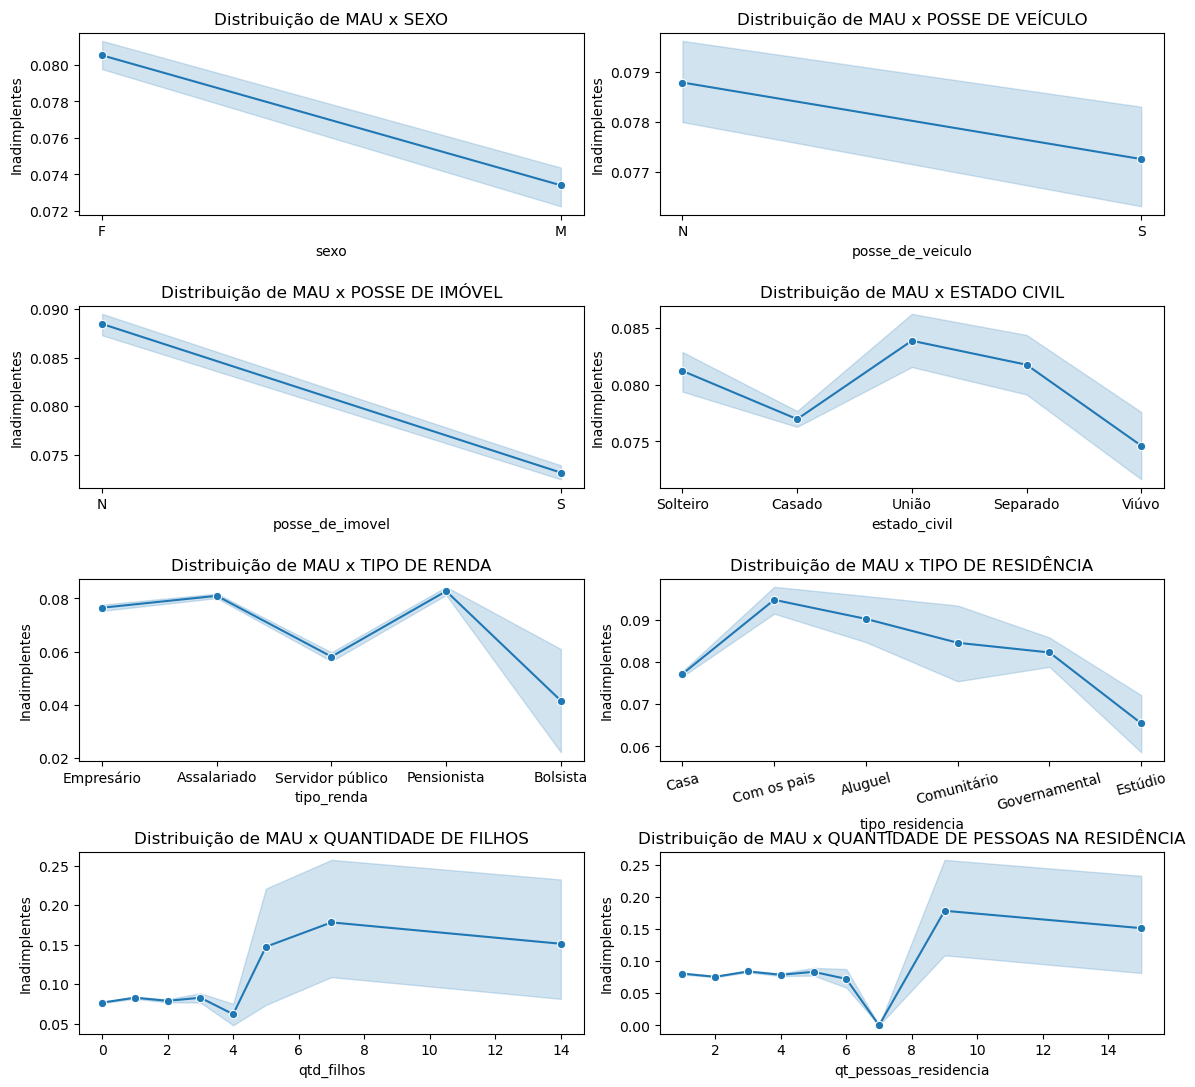

In [12]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(14, 13))

sns.lineplot(data=df_1, x='sexo', y='mau', ax=ax[0, 0], marker='o')
ax[0, 0].set_title('Distribuição de MAU x SEXO')
ax[0, 0].set_ylabel("Inadimplentes")

sns.lineplot(data=df_1, x='posse_de_veiculo', y='mau', ax=ax[0, 1], marker='o')
ax[0, 1].set_title('Distribuição de MAU x POSSE DE VEÍCULO')
ax[0, 1].set_ylabel("Inadimplentes")

sns.lineplot(data=df_1, x='posse_de_imovel', y='mau', ax=ax[1, 0], marker='o')
ax[1, 0].set_title('Distribuição de MAU x POSSE DE IMÓVEL')
ax[1, 0].set_ylabel("Inadimplentes")

sns.lineplot(data=df_1, x='estado_civil', y='mau', ax=ax[1, 1], marker='o')
ax[1, 1].set_title('Distribuição de MAU x ESTADO CIVIL')
ax[1, 1].set_ylabel("Inadimplentes")

sns.lineplot(data=df_1, x='tipo_renda', y='mau', ax=ax[2, 0], marker='o')
ax[2, 0].set_title('Distribuição de MAU x TIPO DE RENDA')
ax[2, 0].set_ylabel("Inadimplentes")

sns.lineplot(data=df_1, x='tipo_residencia', y='mau', ax=ax[2, 1], marker='o')
ax[2, 1].set_title('Distribuição de MAU x TIPO DE RESIDÊNCIA')
ax[2, 1].set_ylabel("Inadimplentes")
for tick in ax[2, 1].get_xticklabels():
    tick.set_rotation(15)
    
sns.lineplot(data=df_1, x='qtd_filhos', y='mau', ax=ax[3, 0], marker='o')
ax[3, 0].set_title('Distribuição de MAU x QUANTIDADE DE FILHOS')
ax[3, 0].set_ylabel("Inadimplentes")

sns.lineplot(data=df_1, x='qt_pessoas_residencia', y='mau', ax=ax[3, 1], marker='o')
ax[3, 1].set_title('Distribuição de MAU x QUANTIDADE DE PESSOAS NA RESIDÊNCIA')
ax[3, 1].set_ylabel("Inadimplentes")

plt.subplots_adjust(wspace=0.15, hspace=0.5)
plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [13]:
df.isna().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [14]:
df['tempo_emprego'].fillna(value=df['tempo_emprego'].mean(), inplace=True)

In [15]:
info = pd.DataFrame(df.dtypes, columns=['dtype'])
info['valores_unicos'] = df.nunique()

info

,dtype,valores_unicos
data_ref,datetime64[ns],15
index,int64,16650
sexo,object,2
posse_de_veiculo,object,2
posse_de_imovel,object,2
qtd_filhos,int64,8
tipo_renda,object,5
educacao,object,5
estado_civil,object,5
tipo_residencia,object,6


In [16]:
df['mau'] = df.mau.astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          750000 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

In [17]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [18]:
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['valores_unicos'] = df.nunique()
metadados['variavel'] = 'covariavel'
metadados.loc['mau','variavel'] = 'resposta'
metadados.loc['bom','variavel'] = 'resposta'

for var in metadados[metadados.variavel=='covariavel'].index:
    if (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)
    else:
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)        
        
metadados

,dtype,valores_unicos,variavel,IV
data_ref,datetime64[ns],15.0,covariavel,0.345982
index,int64,16650.0,covariavel,0.002664
sexo,object,2.0,covariavel,0.002185
posse_de_veiculo,object,2.0,covariavel,0.000108
posse_de_imovel,object,2.0,covariavel,0.009693
qtd_filhos,int64,8.0,covariavel,0.000030
tipo_renda,object,5.0,covariavel,0.009360
educacao,object,5.0,covariavel,0.003547
estado_civil,object,5.0,covariavel,0.001126
tipo_residencia,object,6.0,covariavel,0.003045


In [19]:
metadados_sorted = metadados.sort_values(by='IV', ascending=False)
metadados_sorted

,dtype,valores_unicos,variavel,IV
renda,float64,142419.0,covariavel,1.068628
data_ref,datetime64[ns],15.0,covariavel,0.345982
tempo_emprego,float64,3005.0,covariavel,0.278819
idade,int64,47.0,covariavel,0.017968
posse_de_imovel,object,2.0,covariavel,0.009693
tipo_renda,object,5.0,covariavel,0.009360
educacao,object,5.0,covariavel,0.003547
tipo_residencia,object,6.0,covariavel,0.003045
index,int64,16650.0,covariavel,0.002664
sexo,object,2.0,covariavel,0.002185


### Realizando agrupamentos:

In [22]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)
    
    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                       'qt_mau': g['bom'].sum(),
                       'mau':g['bom'].mean(),
                       var: g['bom'].mean().index,
                       'cont':g[var].count()})
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_sup/(1-biv.mau_inf))
    
    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))
    
    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral
    
    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe,  ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite superior')
        
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])
    
    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

0.009314630323182816

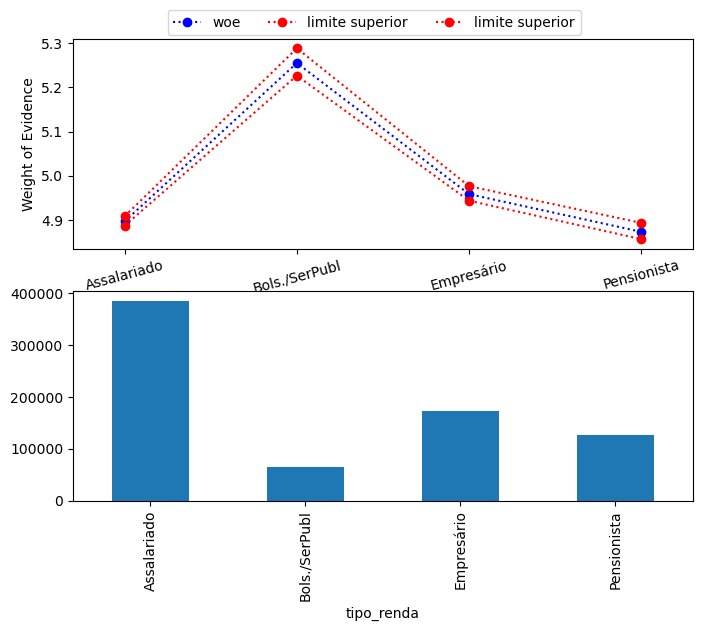

In [23]:
# Copiando dados ajustados 'df' para df2
df2 = df.copy()
df2.tipo_renda.replace({'Bolsista': 'Bols./SerPubl', 'Servidor público': 'Bols./SerPubl'}, inplace=True)
biv_discreta('tipo_renda', df2)
IV(df2.tipo_renda, df.mau)

0.003546241385773477

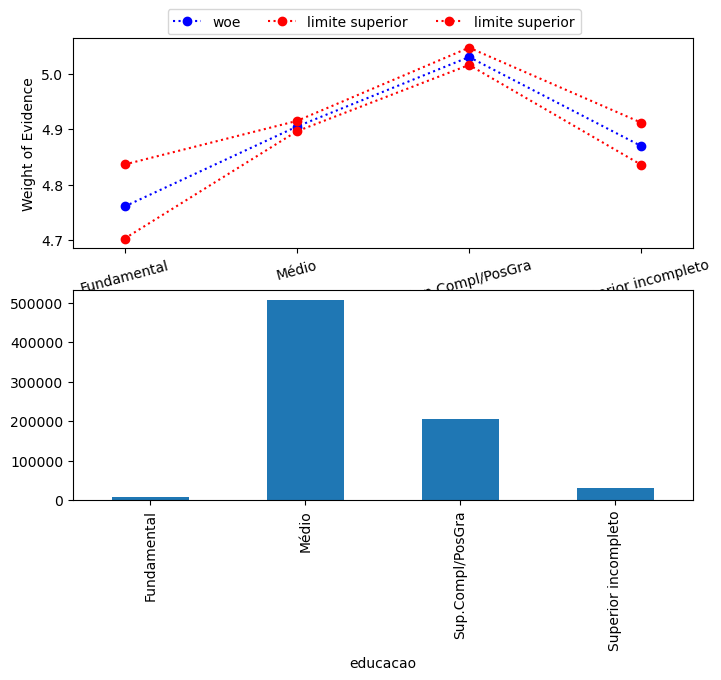

In [24]:
df2.educacao.replace({'Superior completo': 'Sup.Compl/PosGra', 'Pós graduação': 'Sup.Compl/PosGra'}, inplace=True)
biv_discreta('educacao', df2)
IV(df2.educacao, df.mau)

0.0023941390471014087

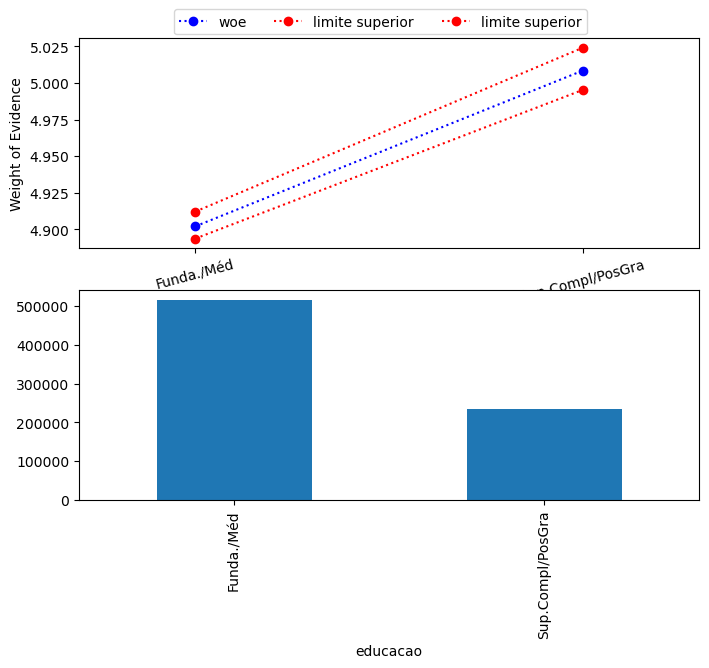

In [25]:
df2.educacao.replace({'Superior incompleto':'Sup.Compl/PosGra', 
                      'Fundamental':'Funda./Méd',
                      'Médio': 'Funda./Méd'
                     }, inplace=True)
biv_discreta('educacao', df2)
IV(df2.educacao, df.mau)

In [26]:
' + '.join(list(metadados_sorted.index))

'renda + data_ref + tempo_emprego + idade + posse_de_imovel + tipo_renda + educacao + tipo_residencia + index + sexo + qt_pessoas_residencia + estado_civil + posse_de_veiculo + qtd_filhos + mau + bom'

In [27]:
formula = 'mau ~ renda + tempo_emprego'

rl = smf.glm(formula, data=df2, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               750000
Model:                            GLM   Df Residuals:                   749997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.8378e+05
Date:                Sun, 18 Feb 2024   Deviance:                   3.6735e+05
Time:                        22:51:33   Pearson chi2:                 4.69e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.05690
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.3150      0.009   -153.239      0.000      -1.332      -1.298
renda            -0.0001   1.04e-06   -123.962      0.000      -0.000      -0.000
tempo_emprego    -0.0256      0.001    -19.714      0.000      -0.028      -0.023
=================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [28]:
result_model = df2.copy()

result_model['score'] = rl.predict(result_model)

# Acurácia
acc = metrics.accuracy_score(result_model.mau, result_model.score > .068)

# AUC
fpr, tpr, thresholds = metrics.roc_curve(result_model.mau, result_model.score)
auc = metrics.auc(fpr, tpr)

# Gini
gini = 2*auc - 1
ks = ks_2samp(result_model.loc[result_model.mau == 1, 'score'],
              result_model.loc[result_model.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'.format(acc, auc, gini, ks))

Acurácia: 52.5% 
AUC: 77.9% 
GINI: 55.7%
KS: 41.7%


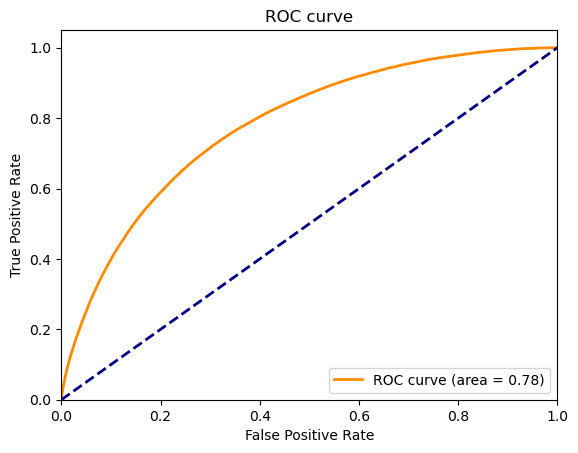

In [29]:
fpr, tpr, thresholds = metrics.roc_curve(result_model['mau'], result_model['score'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(result_model['mau'], result_model['score'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

In [144]:
from pycaret.classification import *
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

In [145]:
X_digits, y_digits = load_digits(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, test_size=0.3, random_state=10)

pca = PCA(n_components=20)
scaler = StandardScaler()
logistic = LogisticRegression(max_iter=200)

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [146]:
X_digits.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [147]:
X_digits.shape

(1797, 64)

In [148]:
X_train.shape

(1257, 64)

In [149]:
# Fitting em treino
scaler.fit(X_train)
X_train = scaler.transform(X_train)

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [150]:
pca.fit(X_train)
X_train =  pca.transform(X_train)

In [151]:
# Fitting e predicting em treino
logistic.fit(X_train, y_train)

logistic.predict(X_train)

array([0, 0, 0, ..., 2, 1, 2])

In [152]:
# Aplicando StandardScaler nos dados de teste
X_test = scaler.transform(X_test)

In [153]:
# Aplicando PCA nos dados de teste 
X_test = pca.transform(X_test)


In [154]:
# Predicting em teste
logistic.predict(X_test)

array([5, 2, 5, 4, 8, 3, 4, 3, 3, 0, 8, 7, 0, 1, 8, 6, 9, 7, 9, 7, 1, 6,
       6, 7, 8, 8, 5, 8, 9, 9, 3, 3, 7, 3, 4, 1, 9, 2, 5, 4, 2, 1, 0, 1,
       2, 9, 6, 1, 9, 4, 4, 5, 8, 4, 8, 5, 9, 7, 8, 0, 4, 5, 8, 4, 7, 9,
       0, 7, 1, 3, 9, 3, 3, 8, 0, 7, 3, 6, 5, 2, 0, 8, 8, 0, 1, 2, 2, 8,
       8, 8, 2, 6, 3, 4, 7, 9, 8, 2, 9, 2, 5, 0, 8, 0, 4, 8, 8, 0, 6, 7,
       3, 3, 9, 1, 2, 4, 6, 0, 8, 8, 1, 1, 7, 9, 9, 5, 2, 3, 3, 9, 7, 6,
       2, 5, 4, 3, 8, 7, 6, 7, 2, 7, 4, 9, 5, 1, 9, 8, 6, 1, 8, 1, 4, 0,
       9, 9, 1, 2, 3, 5, 0, 3, 4, 1, 5, 4, 9, 3, 5, 6, 4, 0, 8, 6, 7, 0,
       9, 9, 4, 7, 5, 5, 2, 0, 6, 7, 5, 3, 9, 7, 1, 3, 2, 8, 3, 3, 1, 7,
       1, 1, 1, 7, 1, 6, 7, 6, 9, 5, 2, 3, 5, 2, 9, 5, 4, 8, 2, 9, 1, 5,
       4, 2, 3, 9, 0, 2, 0, 2, 1, 0, 5, 0, 6, 4, 2, 1, 9, 0, 9, 0, 6, 9,
       4, 4, 9, 7, 5, 6, 1, 5, 7, 0, 8, 6, 2, 5, 1, 2, 3, 8, 4, 4, 3, 5,
       7, 9, 7, 2, 0, 2, 0, 9, 2, 8, 6, 3, 1, 0, 6, 6, 6, 7, 1, 6, 1, 7,
       6, 0, 6, 3, 7, 4, 6, 2, 2, 0, 8, 4, 7, 3, 3,

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, test_size=0.3, random_state=10)

pca_pipe = PCA(n_components=15)
scaler_pipe = StandardScaler()
logistic_pipe = LogisticRegression(max_iter=200)


In [156]:
pipe = Pipeline(steps=[("scaler", scaler_pipe), 
                       ("pca", pca_pipe), 
                       ("logistic", logistic_pipe)])

In [157]:
pipe.named_steps

{'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'pca': PCA(copy=True, iterated_power='auto', n_components=15, n_oversamples=10,
     power_iteration_normalizer='auto', random_state=None, svd_solver='auto',
     tol=0.0, whiten=False),
 'logistic': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=200,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False)}

In [158]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=15,
                     n_oversamples=10, power_iteration_normalizer='auto',
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('logistic',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=200,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [159]:
pipe.predict(X_train)

array([0, 0, 0, ..., 1, 8, 2])

In [160]:
pipe.predict(X_test)

array([5, 2, 5, 4, 8, 1, 4, 3, 3, 0, 8, 7, 0, 1, 8, 6, 9, 7, 9, 7, 1, 6,
       6, 7, 8, 8, 5, 8, 9, 9, 3, 3, 7, 3, 4, 1, 9, 2, 5, 4, 2, 1, 0, 1,
       2, 3, 6, 1, 9, 4, 4, 9, 8, 4, 8, 5, 9, 7, 1, 0, 4, 5, 8, 4, 7, 9,
       0, 7, 1, 3, 3, 3, 3, 8, 0, 7, 3, 6, 5, 2, 0, 8, 8, 0, 1, 2, 2, 8,
       8, 8, 2, 6, 3, 4, 7, 9, 8, 2, 9, 2, 5, 0, 8, 0, 4, 8, 8, 0, 6, 7,
       3, 3, 9, 1, 2, 4, 6, 0, 8, 8, 1, 1, 7, 8, 9, 5, 2, 3, 3, 9, 7, 6,
       2, 5, 4, 3, 8, 4, 6, 7, 2, 7, 4, 9, 5, 1, 9, 8, 6, 1, 8, 1, 4, 0,
       9, 9, 1, 2, 3, 5, 0, 3, 4, 1, 5, 4, 9, 3, 5, 6, 4, 0, 8, 6, 7, 0,
       9, 9, 4, 7, 9, 5, 2, 0, 6, 7, 5, 3, 9, 7, 1, 3, 2, 8, 8, 3, 1, 7,
       1, 1, 1, 7, 1, 6, 7, 6, 9, 5, 2, 3, 5, 2, 9, 5, 4, 8, 2, 0, 1, 5,
       4, 2, 3, 9, 0, 2, 0, 2, 1, 0, 5, 0, 6, 4, 2, 1, 9, 0, 9, 0, 6, 9,
       4, 4, 9, 7, 5, 6, 1, 8, 7, 0, 8, 6, 2, 5, 1, 2, 3, 8, 4, 4, 3, 5,
       7, 9, 7, 2, 0, 2, 0, 9, 2, 8, 6, 3, 1, 0, 6, 6, 6, 7, 1, 6, 1, 7,
       6, 0, 6, 3, 7, 4, 6, 2, 2, 0, 8, 4, 7, 3, 3,

In [161]:
pipe.named_steps

{'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'pca': PCA(copy=True, iterated_power='auto', n_components=15, n_oversamples=10,
     power_iteration_normalizer='auto', random_state=None, svd_solver='auto',
     tol=0.0, whiten=False),
 'logistic': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=200,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False)}

In [162]:
pipe.steps

[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('pca',
  PCA(copy=True, iterated_power='auto', n_components=15, n_oversamples=10,
      power_iteration_normalizer='auto', random_state=None, svd_solver='auto',
      tol=0.0, whiten=False)),
 ('logistic',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=200,
                     multi_class='auto', n_jobs=None, penalty='l2',
                     random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                     warm_start=False))]

In [163]:
pipe[0]

StandardScaler(copy=True, with_mean=True, with_std=True)

In [164]:
pipe[1]

PCA(copy=True, iterated_power='auto', n_components=15, n_oversamples=10,
    power_iteration_normalizer='auto', random_state=None, svd_solver='auto',
    tol=0.0, whiten=False)

In [165]:
pipe[2]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [166]:
pipe[1].transform(X_train)

array([[  0.87099173, -12.61625782, -18.95625634, ...,   5.14500199,
         16.15068695,   3.8213878 ],
       [  7.39000586,  -7.8463503 , -16.49064676, ...,   8.51957807,
         20.05695108,   2.76877824],
       [  8.28998706, -10.02871848, -14.17160119, ...,   9.06599293,
         27.45682091,   4.07261947],
       ...,
       [-12.90637376, -12.77042082,  16.69146886, ...,   1.57623211,
         10.46191031,   6.63962284],
       [-12.20194919,  -2.5879745 ,   7.00733009, ...,   8.70262076,
          9.89176106,   2.72512308],
       [-11.21461305,   2.61272315,   2.68282997, ...,   4.07881385,
         18.77844504,  -4.77009065]])

In [167]:
pca_pipe.transform(X_train)

array([[  0.87099173, -12.61625782, -18.95625634, ...,   5.14500199,
         16.15068695,   3.8213878 ],
       [  7.39000586,  -7.8463503 , -16.49064676, ...,   8.51957807,
         20.05695108,   2.76877824],
       [  8.28998706, -10.02871848, -14.17160119, ...,   9.06599293,
         27.45682091,   4.07261947],
       ...,
       [-12.90637376, -12.77042082,  16.69146886, ...,   1.57623211,
         10.46191031,   6.63962284],
       [-12.20194919,  -2.5879745 ,   7.00733009, ...,   8.70262076,
          9.89176106,   2.72512308],
       [-11.21461305,   2.61272315,   2.68282997, ...,   4.07881385,
         18.77844504,  -4.77009065]])

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [168]:
dummy = pd.get_dummies(df, columns=['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'])

In [169]:
dummy

,data_ref,index,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,bom,sexo_F,...,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Aluguel,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,2015-01-01,5733,0,43,6.873973,1.0,2515.39,0,1,1,...,0,1,0,0,0,1,0,0,0,0
1,2015-01-01,727,0,35,4.526027,2.0,3180.19,0,1,1,...,0,0,0,0,0,1,0,0,0,0
2,2015-01-01,6374,2,31,0.243836,4.0,1582.29,0,1,1,...,0,0,0,0,0,1,0,0,0,0
3,2015-01-01,9566,0,54,12.772603,2.0,13721.17,0,1,1,...,0,0,0,0,0,1,0,0,0,0
4,2015-01-01,9502,0,31,8.432877,1.0,2891.08,0,1,1,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,13689,0,48,3.038356,2.0,2109.99,0,1,0,...,0,0,0,0,0,1,0,0,0,0
749996,2016-03-01,7000,0,65,NaN,1.0,1389.39,0,1,1,...,0,1,0,0,0,1,0,0,0,0
749997,2016-03-01,14023,2,43,10.375342,4.0,649.06,1,0,0,...,0,0,0,0,0,1,0,0,0,0
749998,2016-03-01,2396,0,56,13.780822,1.0,4216.72,1,0,1,...,0,0,0,1,0,1,0,0,0,0


In [170]:
dummy.dtypes

data_ref                         datetime64[ns]
index                                     int64
qtd_filhos                                int64
idade                                     int64
tempo_emprego                           float64
qt_pessoas_residencia                   float64
renda                                   float64
mau                                       int64
bom                                       int64
sexo_F                                    uint8
sexo_M                                    uint8
posse_de_veiculo_N                        uint8
posse_de_veiculo_S                        uint8
posse_de_imovel_N                         uint8
posse_de_imovel_S                         uint8
tipo_renda_Assalariado                    uint8
tipo_renda_Bolsista                       uint8
tipo_renda_Empresário                     uint8
tipo_renda_Pensionista                    uint8
tipo_renda_Servidor público               uint8
educacao_Fundamental                    

### Definindo modelo de Regressão Logística:

In [172]:
df = pd.read_feather('credit_scoring.ftr')

In [173]:
df.shape

(750000, 15)

In [174]:
df.columns

Index(['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau'],
      dtype='object')

In [175]:
dataset = df.sample(40000)

In [176]:
dataset.drop(['data_ref','index'], axis=1, inplace=True)

In [177]:
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (38000, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (2000, 13)


In [179]:
data.dtypes

sexo                      object
posse_de_veiculo          object
posse_de_imovel           object
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
mau                         bool
dtype: object

In [180]:
data.qtd_filhos = data.qtd_filhos.astype(float)

In [181]:
data.corr()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
qtd_filhos,1.000000,-0.368875,-0.082114,0.890765,-0.045808,0.008168
idade,-0.368875,1.000000,0.327901,-0.340443,0.103643,-0.028581
tempo_emprego,-0.082114,0.327901,1.000000,-0.072359,0.509680,-0.139000
qt_pessoas_residencia,0.890765,-0.340443,-0.072359,1.000000,-0.048888,0.007849
renda,-0.045808,0.103643,0.509680,-0.048888,1.000000,-0.068640
mau,0.008168,-0.028581,-0.139000,0.007849,-0.068640,1.000000


In [182]:
data.mau.value_counts(normalize=True)

False    0.922421
True     0.077579
Name: mau, dtype: float64

In [183]:
exp_aula4 = setup(data = data, target = 'mau', experiment_name='credit_1',
                  normalize=True, normalize_method='zscore', 
                  transformation=True, transformation_method = 'quantile',
                  fix_imbalance=True)



,Description,Value
0,Session id,5764
1,Target,mau
2,Target type,Binary
3,Original data shape,"(38000, 13)"
4,Transformed data shape,"(60472, 30)"
5,Transformed train set shape,"(49072, 30)"
6,Transformed test set shape,"(11400, 30)"
7,Ordinal features,3
8,Numeric features,5
9,Categorical features,7


In [184]:
best_model = compare_models(fold=4, sort='AUC')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:52:39
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9200,0.7751,0.0635,0.4029,0.1092,0.0900,0.1346,11.5750
lightgbm,Light Gradient Boosting Machine,0.9200,0.7700,0.0572,0.3932,0.0998,0.0817,0.1259,2.0050
ada,Ada Boost Classifier,0.9126,0.7665,0.1129,0.3204,0.1616,0.1279,0.1489,3.9750
lr,Logistic Regression,0.8999,0.7530,0.2078,0.2946,0.2437,0.1918,0.1952,3.3725
lda,Linear Discriminant Analysis,0.8918,0.7279,0.2175,0.2626,0.2377,0.1801,0.1811,0.8225
rf,Random Forest Classifier,0.9026,0.7075,0.1071,0.2273,0.1450,0.1006,0.1088,2.6425
et,Extra Trees Classifier,0.8894,0.6496,0.1274,0.1877,0.1517,0.0949,0.0970,2.2075
nb,Naive Bayes,0.1058,0.6419,0.9845,0.0788,0.1459,0.0026,0.0214,1.9575
knn,K Neighbors Classifier,0.9051,0.6241,0.0766,0.2019,0.1108,0.0716,0.0810,3.9375
qda,Quadratic Discriminant Analysis,0.9223,0.5626,0.0000,0.0000,0.0000,-0.0002,-0.0015,0.7350


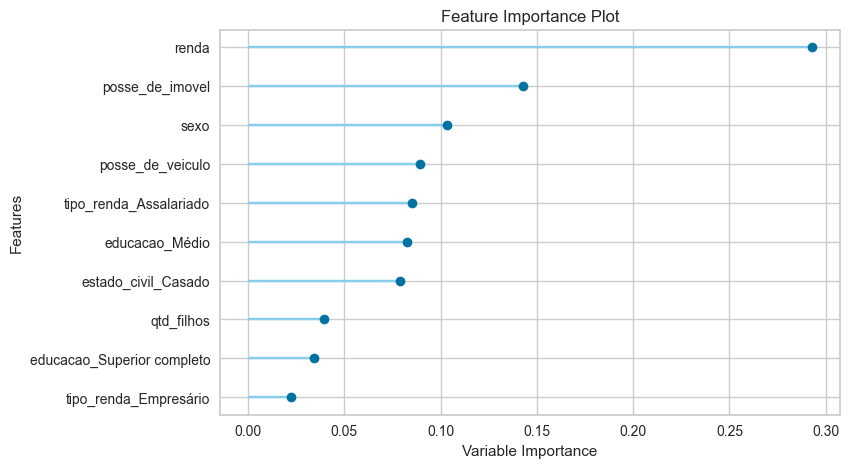

In [185]:

plot_model(best_model, plot='feature')

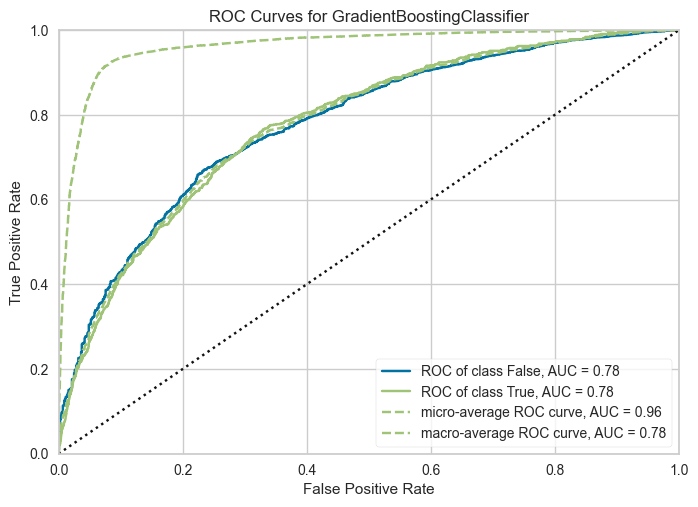

In [186]:
plot_model(best_model, plot='auc')

### Salvar o pickle file do modelo treinado

In [187]:
pip install pickle

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [188]:
import pickle

nome_arquivo = 'model_final.pkl'
pickle.dump(best_model, open(nome_arquivo, 'wb'))

# Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [189]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [190]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [191]:
lightgbm = create_model('lightgbm')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:55:51
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9233,0.7895,0.0485,0.5556,0.0893,0.0778,0.1476
1,0.9165,0.7825,0.0437,0.2647,0.0750,0.0542,0.0797
2,0.9192,0.8006,0.0291,0.2857,0.0529,0.0391,0.0695
3,0.9211,0.7489,0.0728,0.4412,0.1250,0.1054,0.1548
4,0.9226,0.7768,0.0825,0.5000,0.1417,0.1224,0.1799
5,0.9222,0.7758,0.0631,0.4815,0.1116,0.0954,0.1531
6,0.9195,0.7660,0.0435,0.3600,0.0776,0.0619,0.1026
7,0.9169,0.7435,0.0242,0.2083,0.0433,0.0276,0.0465
8,0.9203,0.7469,0.0773,0.4324,0.1311,0.1101,0.1572


In [192]:
tuned_lightgbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9226,0.7949,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9226,0.7760,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.9226,0.8009,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.9229,0.7424,0.0049,1.0000,0.0097,0.0089,0.0669
4,0.9226,0.7661,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.9226,0.7780,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.9222,0.7672,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.9222,0.7450,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.9222,0.7549,0.0000,0.0000,0.0000,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [193]:
final_lightgbm = finalize_model(tuned_lightgbm)

In [194]:
evaluate_model(final_lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

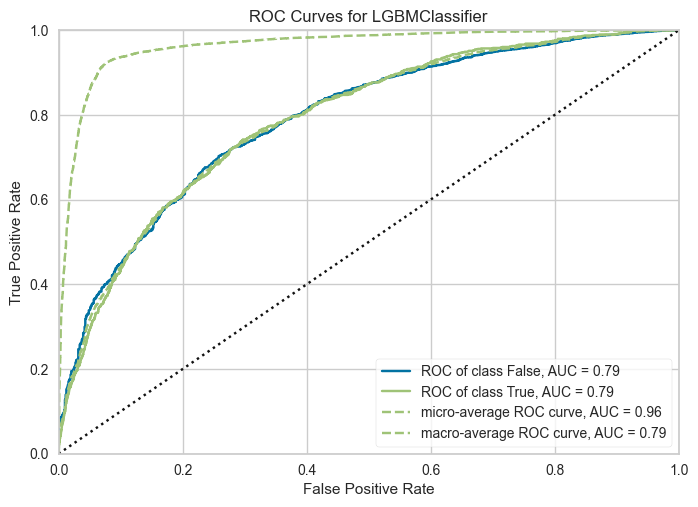

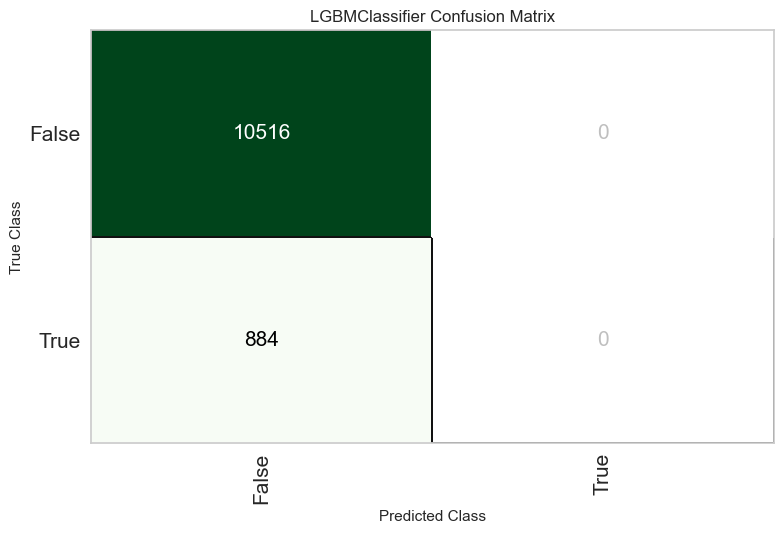

In [195]:
plot_model(final_lightgbm, plot='auc')
plot_model(final_lightgbm, plot='confusion_matrix')

#### Arquivo do Modelo Treinado :

In [196]:
import pickle

nome_arquivo = 'final_lightgbm.pkl'
pickle.dump(final_lightgbm, open(nome_arquivo, 'wb'))